# Capstone Project: Predicting Educational Achievement Gaps

This notebook captures the step-by-step workflow process of using data made availble by Stanford's Center for Educational Analysis (CEPA) to predict the education achievement gap for black and Hispanic students in the United States.

In [217]:
# Import libraries
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model, cross_validation
from sklearn import tree
from sklearn.linear_model import LogisticRegression
import time
from sklearn.metrics import f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from pandas import DataFrame
from sympy import *
from scipy.stats import norm
import matplotlib.mlab as mlab
from sklearn.dummy import DummyClassifier

## Load and prepare the data

Two main datasets are used in this project. One of the datasets is labeled "Covariates", which is used to grab features for our machine learning (ML) algorithms. The labels are determined by the "Gaps" dataset.

In [5]:
# Import data
## Covariates dataset
cvrts = pd.read_csv('district by year covariates from acs and ccd master_v1_1.csv')
## Gaps dataset
gaps = pd.read_csv('district_gaps_by_year_grade_subject_long_file_v1_1.csv')

In [6]:
# See top 10 rows in covriates dataset
cvrts.head(10)

,leaid,leaname,year,fips,stateabb,metroid,metromicro,czid,countyid,cdcode,...,sesblk,seshsp,sesallimp1,sesallimp2,seswhtimp1,seswhtimp2,sesblkimp1,sesblkimp2,seshspimp1,seshspimp2
0,100005,ALBERTVILLE CITY,2009,1,AL,10700.0,2.0,558.0,1095.0,104.0,...,-3.616497,-2.304082,0,0,0,0,0,0,0,0
1,100005,ALBERTVILLE CITY,2010,1,AL,10700.0,2.0,558.0,1095.0,104.0,...,-3.616497,-2.304082,0,0,0,0,0,0,0,0
2,100005,ALBERTVILLE CITY,2011,1,AL,10700.0,2.0,558.0,1095.0,104.0,...,-3.616497,-2.304082,0,0,0,0,0,0,0,0
3,100005,ALBERTVILLE CITY,2012,1,AL,10700.0,2.0,558.0,1095.0,104.0,...,-3.616497,-2.304082,0,0,0,0,0,0,0,0
4,100005,ALBERTVILLE CITY,2013,1,AL,10700.0,2.0,558.0,1095.0,104.0,...,-3.616497,-2.304082,0,0,0,0,0,0,0,0
5,100006,MARSHALL COUNTY,2009,1,AL,10700.0,2.0,558.0,1095.0,104.0,...,0.528701,-0.578827,0,0,0,0,0,0,0,0
6,100006,MARSHALL COUNTY,2010,1,AL,10700.0,2.0,558.0,1095.0,104.0,...,0.528701,-0.578827,0,0,0,0,0,0,0,0
7,100006,MARSHALL COUNTY,2011,1,AL,10700.0,2.0,558.0,1095.0,104.0,...,0.528701,-0.578827,0,0,0,0,0,0,0,0
8,100006,MARSHALL COUNTY,2012,1,AL,10700.0,2.0,558.0,1095.0,104.0,...,0.528701,-0.578827,0,0,0,0,0,0,0,0
9,100006,MARSHALL COUNTY,2013,1,AL,10700.0,2.0,558.0,1095.0,104.0,...,0.528701,-0.578827,0,0,0,0,0,0,0,0


As the covarites dataset shows, there are multiple years under consideration (2009-2013) and more than  a 150 columns containing data that may be used in the ML models. Therefore, it is necessary to go through the column names and descriptions in the codebook provided by CEPA in order to determine what columns are relevant for our purposes. 

In [7]:
# List the column names in covariates dataset
list(cvrts)

['leaid',
 'leaname',
 'year',
 'fips',
 'stateabb',
 'metroid',
 'metromicro',
 'czid',
 'countyid',
 'cdcode',
 'urban',
 'avgrdall',
 'avgrdwht',
 'avgrdblk',
 'avgrdhsp',
 'perind',
 'perasn',
 'perhsp',
 'perblk',
 'perwht',
 'perfrl',
 'pernonfrl',
 'perell',
 'perspeced',
 'ind',
 'asn',
 'hsp',
 'blk',
 'wht',
 'frl',
 'nonfrl',
 'totenrl',
 'nsch',
 'ncharters',
 'speced',
 'ell',
 'elmtch',
 'tottch',
 'aides',
 'corsup',
 'elmgui',
 'stutch_wht',
 'stutch_blk',
 'stutch_hsp',
 'stutch_all',
 'diffstutch_blkwht',
 'diffstutch_hspwht',
 'ratstutch_whtblk',
 'ratstutch_whthsp',
 'flunch_all',
 'flunch_wht',
 'flunch_blk',
 'flunch_hsp',
 'diffexplch_blkwht',
 'diffexplch_hspwht',
 'hswhtblk',
 'hswhthsp',
 'hsflnfl',
 'ppexp_tot',
 'ppexp_inst',
 'pprev_tot',
 'percharter_all',
 'percharter_wht',
 'percharter_blk',
 'percharter_hsp',
 'totppe_fleslope',
 'instppe_fleslope',
 'gslo',
 'gshi',
 'profocc_wht',
 'baplus_wht',
 'poverty517_wht',
 'snap_wht',
 'rent_wht',
 'singmom_w

By going through the names of the covariate column names, it is clear that some columns are transforamation of other columns and the data is already split between the black-white and Hispanic-white gaps. Therefore, a subset of covarite column names is indentified for the ML models stored in "covariates_subset.csv" This manual reduces the number of features used for the ML from over 150 to 41 for black and Hispanic students. It is recommened to go over the covariate definitions in the "codebook_covariates_v1_1" Excel file. 

In [8]:
# Import covariates subset
cvrts_sub = pd.read_csv('covariates_subset.csv')

In [9]:
cvrts_sub.head(10)

,cvrts_blk,cvrts_hsp
0,leaid,leaid
1,year,year
2,urban,urban
3,perblk,perhsp
4,perell,perell
5,perspeced,perspeced
6,perfrl,perfrl
7,stutch_blk,stutch_hsp
8,percharter_blk,percharter_hsp
9,hswhtblk,hswhthsp


In [10]:
# Define black and Hispanic covariate column names
cvrts_blk = cvrts_sub.cvrts_blk
cvrts_hsp = cvrts_sub.cvrts_hsp

Now that the covariates dataset has been reduced to more meaninful features for black and Hispanic students, the next step is to go through the achievement gaps dataset. The achievement gap dataset catpures gaps between the black and white populations, as well as gaps between the white and hispanic groups.

In [11]:
# See top 10 rows in the gaps dataset
gaps.head(10)

,leaid,leaname,fips,stateabb,year,grade,gapblk_ela,gapseblk_ela,gaphsp_ela,gapsehsp_ela,gapblk_math,gapseblk_math,gaphsp_math,gapsehsp_math,racepercent_ela,racepercent_math,fipst
0,100005,ALBERTVILLE CITY,1,AL,2009,3,NaN,NaN,0.495028,0.144482,NaN,NaN,0.359011,0.142677,1.000000,1.000000,1
1,100005,ALBERTVILLE CITY,1,AL,2009,4,NaN,NaN,0.645853,0.131344,NaN,NaN,0.385385,0.128722,1.000000,1.000000,1
2,100005,ALBERTVILLE CITY,1,AL,2009,5,NaN,NaN,0.877928,0.141010,NaN,NaN,0.537650,0.144171,1.000000,1.000000,1
3,100005,ALBERTVILLE CITY,1,AL,2009,6,NaN,NaN,0.662599,0.165949,NaN,NaN,0.457464,0.158139,0.992308,0.992337,1
4,100005,ALBERTVILLE CITY,1,AL,2009,7,NaN,NaN,1.062303,0.158241,NaN,NaN,0.849210,0.162989,0.996283,0.996283,1
5,100005,ALBERTVILLE CITY,1,AL,2009,8,NaN,NaN,0.486245,0.150930,NaN,NaN,0.508930,0.154534,0.986254,0.986301,1
6,100006,MARSHALL COUNTY,1,AL,2009,3,NaN,NaN,0.396858,0.136476,NaN,NaN,-0.027113,0.187772,1.000000,1.000000,1
7,100006,MARSHALL COUNTY,1,AL,2009,4,NaN,NaN,0.535172,0.165504,NaN,NaN,0.137042,0.164601,1.000000,1.000000,1
8,100006,MARSHALL COUNTY,1,AL,2009,5,NaN,NaN,0.385303,0.149603,NaN,NaN,0.170647,0.163453,1.000000,1.000000,1
9,100006,MARSHALL COUNTY,1,AL,2009,6,NaN,NaN,0.471686,0.137514,NaN,NaN,0.528488,0.175747,1.000000,1.000000,1


The gaps' top 10 rows show the school district identification number and academic year similar to the covariates dataset. However, the gaps dataset is also split by grade level. This means that the covariates data needs to be used multiple times for a given school district for it to span all grade levels. Also, the achievement gaps are split by race and subject. It is helpful to transform the dataset where the gap information is in one column.

In [22]:
# Function to transform gaps dataset
def reformat_gaps(data):
    ## column names for new dataframe
    ## only relevant columns are kept
    columns = ['leaid','year','grade','subject','race','gap','gapse']
    ## intialize empty dataframe
    df = pd.DataFrame(columns=columns)
    ## for loop to append to new dataframe
    for i in range(data.shape[0]):
        # blk_ela: black-white English Language Arts (ELA) gaps
        if np.isnan(data.ix[i]['gapblk_ela']) != True:
            df = df.append({'leaid':int(data.ix[i]['leaid']),
                            'year':int(data.ix[i]['year']),
                            'grade':int(data.ix[i]['grade']),
                            'subject':'ela',
                            'race':'blk',
                            'gap':data.ix[i]['gapblk_ela'],
                            'gapse':data.ix[i]['gapseblk_ela']},
                            ignore_index=True)
        # blk_math: black-white math gaps
        if np.isnan(data.ix[i]['gapblk_math']) != True:
            df = df.append({'leaid':int(data.ix[i]['leaid']),
                            'year':int(data.ix[i]['year']),
                            'grade':int(data.ix[i]['grade']),
                            'subject':'math',
                            'race':'blk',
                            'gap':data.ix[i]['gapblk_math'],
                            'gapse':data.ix[i]['gapseblk_math']},
                            ignore_index=True)
        # hsp_ela: Hispanic-white ELA gaps
        if np.isnan(data.ix[i]['gaphsp_ela']) != True:
            df = df.append({'leaid':int(data.ix[i]['leaid']),
                            'year':int(data.ix[i]['year']),
                            'grade':int(data.ix[i]['grade']),
                            'subject':'ela',
                            'race':'hsp',
                            'gap':data.ix[i]['gaphsp_ela'],
                            'gapse':data.ix[i]['gapsehsp_ela']},
                            ignore_index=True)
        # hsp_math: Hispanic-white math gaps
        if np.isnan(data.ix[i]['gaphsp_math']) != True:
            df = df.append({'leaid':int(data.ix[i]['leaid']),
                            'year':int(data.ix[i]['year']),
                            'grade':int(data.ix[i]['grade']),
                            'subject':'math',
                            'race':'hsp',
                            'gap':data.ix[i]['gaphsp_math'],
                            'gapse':data.ix[i]['gapsehsp_math']},
                            ignore_index=True)            
    return df

Given the above covariate subsets and data transformation function, two processed dataframes are created.

In [16]:
# Create new covariate and gaps dataframes
df_cvrts_blk = cvrts[cvrts_blk] ## Covariates for black students
df_cvrts_hsp = cvrts[cvrts_hsp] ## Covariates for Hispanic students
#df_gaps = reformat_gaps(gaps) ## Reformatted gaps data
df_gaps = pd.read_csv('df_gaps.csv')
## NOTE:Running the reformat_gaps() function may take a long time to execute (30 to 50 min.)

## Analysis: Explore and Visualize Data
At this point, the datasets are now more readable for visualizing and collecting statistical information. 

In [13]:
df_cvrts_blk.head(10)

,leaid,year,urban,perblk,perell,perspeced,perfrl,stutch_blk,percharter_blk,hswhtblk,...,occhealth_mal,occhealth_fem,occserv_mal,occserv_fem,occsales_mal,occsales_fem,occtrade_mal,occtrade_fem,inlf_mal,inlf_fem
0,100005,2009,0.0,0.023055,0.204729,0.009353,0.564544,16.373135,0.0,0.000000,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
1,100005,2010,0.0,0.019209,0.197856,0.074561,0.582957,17.533037,0.0,0.000000,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
2,100005,2011,0.0,0.020659,0.144340,0.063481,0.605807,17.023258,0.0,0.000000,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
3,100005,2012,0.0,0.016926,0.143720,0.075604,0.596861,19.678724,0.0,0.000000,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
4,100005,2013,0.0,0.015095,0.000000,0.071009,0.586945,19.696255,0.0,0.000000,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
5,100006,2009,0.0,0.010639,0.071539,0.008942,0.543680,17.631641,0.0,0.058946,...,0.019010,0.082321,0.118897,0.194952,0.117688,0.362307,0.283764,0.029956,0.809937,0.602653
6,100006,2010,0.0,0.009977,0.065778,0.137095,0.566277,15.131523,0.0,0.055178,...,0.019010,0.082321,0.118897,0.194952,0.117688,0.362307,0.283764,0.029956,0.809937,0.602653
7,100006,2011,0.0,0.011351,0.064064,0.135734,0.595752,14.794630,0.0,0.048374,...,0.019010,0.082321,0.118897,0.194952,0.117688,0.362307,0.283764,0.029956,0.809937,0.602653
8,100006,2012,0.0,0.012521,0.055773,0.127359,0.608542,12.592372,0.0,0.024045,...,0.019010,0.082321,0.118897,0.194952,0.117688,0.362307,0.283764,0.029956,0.809937,0.602653
9,100006,2013,0.0,0.010038,0.000000,0.121404,0.639100,13.786980,0.0,0.023953,...,0.019010,0.082321,0.118897,0.194952,0.117688,0.362307,0.283764,0.029956,0.809937,0.602653


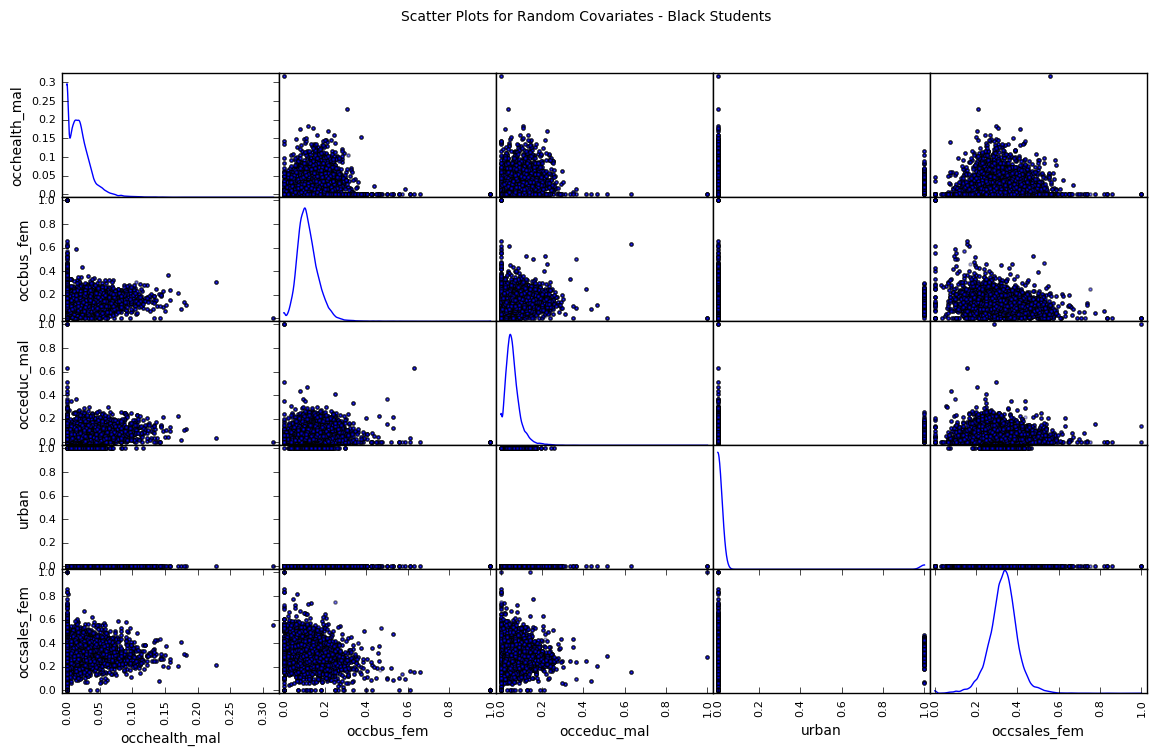

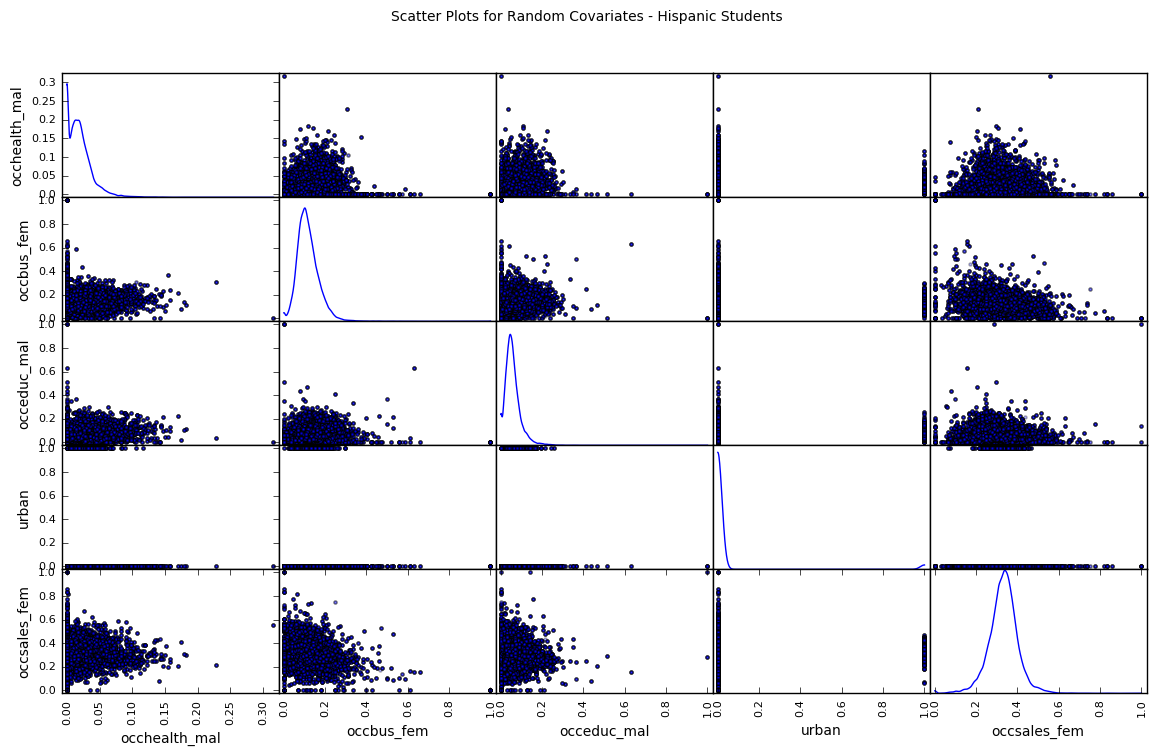

In [14]:
# Create scatter matrix plots for covariate datasets
random_columns = random.sample(range(2,40),5) ## Pick randomly 5 covariates, exculding leaid and year
pd.scatter_matrix(df_cvrts_blk[random_columns], alpha = 0.3, figsize = (14,8), diagonal = 'kde') ## Black students
plt.suptitle('Scatter Plots for Random Covariates - Black Students')
pd.scatter_matrix(df_cvrts_hsp[random_columns], alpha = 0.3, figsize = (14,8), diagonal = 'kde') ## Hispanic students
plt.suptitle('Scatter Plots for Random Covariates - Hispanic Students')

After going through multiple scatter plots, it is observed that the distribution for race-specific covariates have similar distributions. This suggets that the top achievement gap predictors may be similar for black and Hispanic students.

In [17]:
df_gaps.head(10)

,leaid,year,grade,subject,race,gap,gapse
0,100005,2009,3,ela,hsp,0.495028,0.144482
1,100005,2009,3,math,hsp,0.359011,0.142677
2,100005,2009,4,ela,hsp,0.645853,0.131344
3,100005,2009,4,math,hsp,0.385385,0.128722
4,100005,2009,5,ela,hsp,0.877928,0.141010
5,100005,2009,5,math,hsp,0.537650,0.144171
6,100005,2009,6,ela,hsp,0.662599,0.165949
7,100005,2009,6,math,hsp,0.457464,0.158139
8,100005,2009,7,ela,hsp,1.062303,0.158241
9,100005,2009,7,math,hsp,0.849210,0.162989


In [20]:
# Look at overal statistics for black students' achivement gaps
gaps_blk = df_gaps[df_gaps.race == 'blk']['gap']
print(gaps_blk.describe())

count    120460.000000
mean          0.631875
std           0.290091
min          -0.960492
25%           0.444787
50%           0.622558
75%           0.808880
max           2.949480
Name: gap, dtype: float64


In [21]:
# Look at overal statistics for Hispanic students' achivement gaps
gaps_hsp = df_gaps[df_gaps.race == 'hsp']['gap']
print(gaps_hsp.describe())

count    140258.000000
mean          0.501689
std           0.296759
min          -1.534861
25%           0.308188
50%           0.488692
75%           0.683429
max           2.161367
Name: gap, dtype: float64


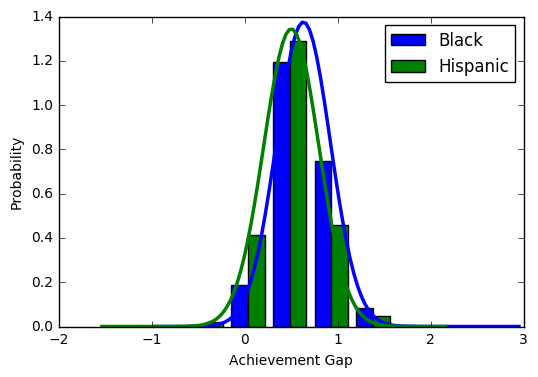

In [91]:
# Create boxplots to compare both student populations

## Histrogram of achievement gaps for black and Hispanic students
n, bins, patches = plt.hist([gaps_blk, gaps_hsp], label=['Black','Hispanic'],
                           normed = 1)

## Create normal distrubtion fit to black student histogram
(mu_blk, sigma_blk) = norm.fit(gaps_blk)
x = np.linspace(min(gaps_blk), max(gaps_blk), 100)
plt.plot(x, mlab.normpdf(x, mu_blk, sigma_blk), 'b', linewidth=2.5)

## Create normal distrubtion fit to Hispanic student histogram
(mu_hsp, sigma_hsp) = norm.fit(gaps_hsp)
x = np.linspace(min(gaps_hsp), max(gaps_hsp), 100)
plt.plot(x, mlab.normpdf(x, mu_hsp, sigma_hsp), 'g', linewidth=2.5)

## Put labels and legend on plot
plt.xlabel('Achievement Gap')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [24]:
# Perform a t-test on the achievement gap distributions
stats.ttest_ind(gaps_blk, gaps_hsp, equal_var=False)

Ttest_indResult(statistic=113.03539386033655, pvalue=0.0)

From the statistical analysis, it shows that the black and Hispanic student groups have their respectective distribution characteristics. The achievement gap for black students is slightly larger by one tenth of a grade level.
T-test shows confirms that the black and Hispanic student populations are different groups. 

## Analysis: Benchmark Model

In this section, linear regression models are used to create the benchmark predictive models. As reported by CEPA, the income gap has a strong correlation with the academic achievement gap. Therefore, the benchkmark model is the fitting of a linear model to the achievement gap as a function of income gap. Before, doing the regression model it is necessary to combine the covariates and gaps data and then split the dataset into training, validation, and test sets. In this case, to build a model that can predicut future achievement gaps. The training and validation test sets consist of academic years from 2009 to 2012. The final test is academic year 2013.

In [25]:
# Create a function that combines the covariate and gaps datasets
# for each race. This function drops any entries with missing values.
def create_dataset2(gaps_data,cvrts_data,years,race):
    ## subsets the gaps_data
    df_g = gaps_data.loc[(gaps_data['year'].isin(years))
                            & (gaps_data.race == race)]
    ## subsets the covriates data
    df_c = cvrts_data.loc[(cvrts_data['year'].isin(years))]
    ## dist_match = set(df_g.leaid) & set(df_c.leaid) #alternate method to merge
    ## merges dataframes based on district and school year
    df_t = pd.merge(df_g,df_c,on=['leaid','year'],how='left')
    ## drop any rows missing entries
    df_t = df_t.dropna()
    ## print(len(dist_match))#to check discrepancy using dropna comman
    return df_t  

In [26]:
# Create main dataframe for black students
yrs = [2009, 2010, 2011, 2012, 2013] #academi years
df_blk = create_dataset2(df_gaps, df_cvrts_blk, yrs, 'blk')
df_blk.head(10)

,leaid,year,grade,subject,race,gap,gapse,urban,perblk,perell,...,occhealth_mal,occhealth_fem,occserv_mal,occserv_fem,occsales_mal,occsales_fem,occtrade_mal,occtrade_fem,inlf_mal,inlf_fem
0,100007,2009,3,ela,blk,0.995519,0.097585,0.0,0.205551,0.049179,...,0.051134,0.124708,0.100437,0.106698,0.25074,0.337614,0.113021,0.004734,0.922635,0.730146
1,100007,2009,3,math,blk,0.899497,0.097678,0.0,0.205551,0.049179,...,0.051134,0.124708,0.100437,0.106698,0.25074,0.337614,0.113021,0.004734,0.922635,0.730146
2,100007,2009,4,ela,blk,1.000924,0.114617,0.0,0.205551,0.049179,...,0.051134,0.124708,0.100437,0.106698,0.25074,0.337614,0.113021,0.004734,0.922635,0.730146
3,100007,2009,4,math,blk,0.862109,0.105707,0.0,0.205551,0.049179,...,0.051134,0.124708,0.100437,0.106698,0.25074,0.337614,0.113021,0.004734,0.922635,0.730146
4,100007,2009,5,ela,blk,0.906164,0.106863,0.0,0.205551,0.049179,...,0.051134,0.124708,0.100437,0.106698,0.25074,0.337614,0.113021,0.004734,0.922635,0.730146
5,100007,2009,5,math,blk,0.867512,0.108235,0.0,0.205551,0.049179,...,0.051134,0.124708,0.100437,0.106698,0.25074,0.337614,0.113021,0.004734,0.922635,0.730146
6,100007,2009,6,ela,blk,0.832009,0.141080,0.0,0.205551,0.049179,...,0.051134,0.124708,0.100437,0.106698,0.25074,0.337614,0.113021,0.004734,0.922635,0.730146
7,100007,2009,6,math,blk,0.815150,0.098378,0.0,0.205551,0.049179,...,0.051134,0.124708,0.100437,0.106698,0.25074,0.337614,0.113021,0.004734,0.922635,0.730146
8,100007,2009,7,ela,blk,0.856107,0.123402,0.0,0.205551,0.049179,...,0.051134,0.124708,0.100437,0.106698,0.25074,0.337614,0.113021,0.004734,0.922635,0.730146
9,100007,2009,7,math,blk,0.999216,0.094230,0.0,0.205551,0.049179,...,0.051134,0.124708,0.100437,0.106698,0.25074,0.337614,0.113021,0.004734,0.922635,0.730146


In [27]:
# Create main dataframe for Hispanic students
df_hsp = create_dataset2(df_gaps, df_cvrts_hsp, yrs, 'hsp')
df_hsp.head(10)

,leaid,year,grade,subject,race,gap,gapse,urban,perhsp,perell,...,occhealth_mal,occhealth_fem,occserv_mal,occserv_fem,occsales_mal,occsales_fem,occtrade_mal,occtrade_fem,inlf_mal,inlf_fem
0,100005,2009,3,ela,hsp,0.495028,0.144482,0.0,0.323307,0.204729,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
1,100005,2009,3,math,hsp,0.359011,0.142677,0.0,0.323307,0.204729,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
2,100005,2009,4,ela,hsp,0.645853,0.131344,0.0,0.323307,0.204729,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
3,100005,2009,4,math,hsp,0.385385,0.128722,0.0,0.323307,0.204729,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
4,100005,2009,5,ela,hsp,0.877928,0.141010,0.0,0.323307,0.204729,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
5,100005,2009,5,math,hsp,0.537650,0.144171,0.0,0.323307,0.204729,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
6,100005,2009,6,ela,hsp,0.662599,0.165949,0.0,0.323307,0.204729,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
7,100005,2009,6,math,hsp,0.457464,0.158139,0.0,0.323307,0.204729,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
8,100005,2009,7,ela,hsp,1.062303,0.158241,0.0,0.323307,0.204729,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587
9,100005,2009,7,math,hsp,0.849210,0.162989,0.0,0.323307,0.204729,...,0.009306,0.072561,0.143854,0.183259,0.120783,0.280584,0.279566,0.001981,0.850765,0.657587


In [28]:
# Split main dataframes into training and final test sets.
# The training set is for both training and validation.
df_blk_train = df_blk[df_blk.year != 2013] ## Train set for training and validation.
df_blk_test = df_blk[df_blk.year == 2013] ## Test set for final test.
df_hsp_train = df_hsp[df_hsp.year != 2013]
df_hsp_test = df_hsp[df_hsp.year == 2013]

In [29]:
# Function adapted from Boston Housing Udacity ML project
# to shuffle split data sets fro training and validation.
def shuffle_split_data(dataset):
    X = dataset.drop(['leaid','year','grade','subject','race','gap','gapse'],axis=1)
    y = dataset.gap
    """ Shuffles and splits data into 70% training and 30% testing subsets,
        then returns the training and testing subsets. """
    ss = cross_validation.ShuffleSplit(len(y), n_iter=5, test_size=0.3, random_state=0)
    # Shuffle and split the data
    for train_index, test_index in ss:
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test

In [30]:
# Split black and Hispanic dataframes into training
# and validation datasets. Validation is labeled as test.
X_train_blk, y_train_blk, X_test_blk, y_test_blk = shuffle_split_data(df_blk_train)
X_train_hsp, y_train_hsp, X_test_hsp, y_test_hsp = shuffle_split_data(df_hsp_train)

## Analysis: Agorithms and Techniques

The ML alogorithms under consideration are: 

- Dummy Classifier:
    Model to baseline the classification models below.
- Decision Tree Classification:
    For the classification techniques, it will be necessary to start binning achievement gaps into groups.
    Top features to feed into Logistic Regression and SVMs
- Logistic Regression:
    Similar to classification, logistic regression may help find trends.
- Support Vector Machines:
    SVMs are known for their high performance, therefore SVMs are considered in order to get high performance. 
    
    

## Methodology: Data Preprocessing

For the Decision Tree Regression, no additional preprocessing is required to identify the top covariates and their contribution to achievement gap prediction. For the classification algorithms, the gaps are binned to classification labels in ranges of one full grade level increments. Normalization is not done because many of the covariates are the same order of magnitude. For example the achievement gaps and income gaps already span a similar range given how the dataset was created.

In [119]:
# Create function to calssify achievement gaps
# in bins of one grade level gaps.
def gap_bin(value):
    if value < -1.25:
        return -3
    elif value < -0.75:
        return -2
    elif value < -0.25:
        return -1
    elif value < 0.25:
        return 0
    elif value < 0.75:
        return 1
    elif value < 1.25:
        return 2
    elif value < 1.75:
        return 3
    else:
        return 4

In [135]:
# Create function to normalize dataframe with feature scaling
def norm_df(df):
    df_norm = (df.max() - df) / (df.max() - df.min())
    return df_norm

## Check normalization function works properly
norm_df(X_test_blk).describe()

,urban,perblk,perell,perspeced,perfrl,stutch_blk,percharter_blk,hswhtblk,baplus_blk,poverty517_blk,...,occhealth_mal,occhealth_fem,occserv_mal,occserv_fem,occsales_mal,occsales_fem,occtrade_mal,occtrade_fem,inlf_mal,inlf_fem
count,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000,...,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000,26790.000000
mean,0.846883,0.750100,0.915195,0.796871,0.550435,0.998402,0.969113,0.897364,0.777737,0.677628,...,0.829899,0.670347,0.679174,0.632862,0.474282,0.463540,0.657582,0.943400,0.186163,0.354246
std,0.360107,0.201070,0.108423,0.064062,0.201639,0.013655,0.089946,0.131830,0.146227,0.188416,...,0.102047,0.098740,0.098845,0.124648,0.128555,0.111887,0.140317,0.055215,0.121237,0.141605
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.635886,0.888744,0.759970,0.395751,0.998377,0.993387,0.862733,0.697713,0.548387,...,0.786183,0.611756,0.621806,0.547038,0.384135,0.390785,0.564528,0.929931,0.103756,0.253054
50%,1.000000,0.811733,0.956881,0.800141,0.535548,0.998681,1.000000,0.944913,0.811145,0.679981,...,0.845865,0.674077,0.689820,0.635359,0.466627,0.459520,0.668555,0.955577,0.160182,0.341629
75%,1.000000,0.908562,0.983983,0.835163,0.707845,0.998912,1.000000,0.984986,0.891993,0.822485,...,0.894765,0.736843,0.746918,0.720294,0.559521,0.533519,0.758708,0.974017,0.234731,0.441877
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Methodology: Implementation

In this section, the aformentioned models are implemented on the training and validation sets.

In [220]:
# Implement the benchmark model of Dummy Classifier
## Create function that implements Dummy Classifier
def dummy_clf(X_train, y_train, X_test, y_test):
    clf = DummyClassifier()
    clf.fit(X_train, y_train.apply(gap_bin))
    y_pred = clf.predict(X_test)
    print "Weighted F1 score for validation set: {}". format (f1_score(y_test.apply(gap_bin), y_pred, 
                                                           pos_label='yes', average='weighted'))


In [235]:
# Determine dummy classification score for black students
dummy_clf(norm_df(X_train_blk), y_train_blk, 
          norm_df(X_test_blk), y_test_blk)

Weighted F1 score for validation set: 0.460453286632


In [236]:
# Determine dummy classification score for Hispanic students
dummy_clf(norm_df(X_train_hsp), y_train_hsp, 
          norm_df(X_test_hsp), y_test_hsp)

Weighted F1 score for validation set: 0.451670549315


In [218]:
# Create function to determine and plot top decistion tree features.
## The inputs are the ML algoirthm (mdl), the feature dataset,
## and the number of top features to be determined (N).
def topfeatures_plot(mdl,X,N):
    weights = mdl.feature_importances_
    tp_indx = weights.argsort()[-N:][::-1]
    tp_wgts = weights[(tp_indx)]
    labels = [None]*N
    for i in range(N):
        labels[i] = list(X)[tp_indx[i]]
    plt.barh(range(N), tp_wgts, align='center')
    plt.yticks(range(N), labels)
    plt.xlabel('Featuer Importance')
    plt.ylabel('Feature')
    plt.show()
    #print(sum(tp_wgts))
    return

# Create function to implement decision and evaluate 
# decistion tree regression performance
def tree_clf_performance(X_train, y_train, X_test, y_test, N):
    mdl = tree.DecisionTreeClassifier()
    mdl.fit(X_train, y_train.apply(gap_bin))
    labels = topfeatures_plot(mdl, X_train, N)
    y_pred = mdl.predict(X_test)
    #print "Score for validation set: {}".format(mdl.score(X_test, y_test.apply(gap_bin)))
    print "Weighted F1 score for validation set: {}". format (f1_score(y_test.apply(gap_bin), y_pred, 
                                                           pos_label='yes', average='weighted'))

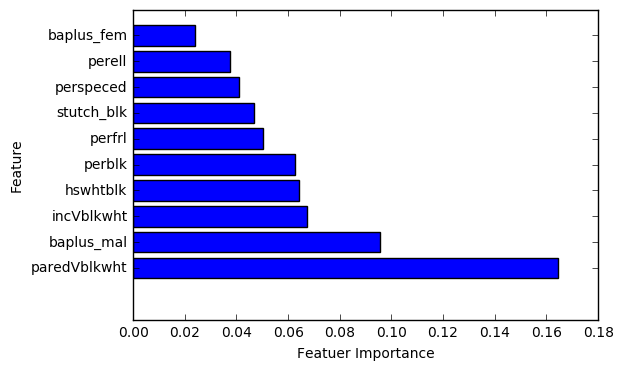

Weighted F1 score for validation set: 0.655302252211


In [219]:
# Decision Tree Classifier performance for black students
tree_clf_performance(norm_df(X_train_blk), y_train_blk, norm_df(X_test_blk), y_test_blk, 10)

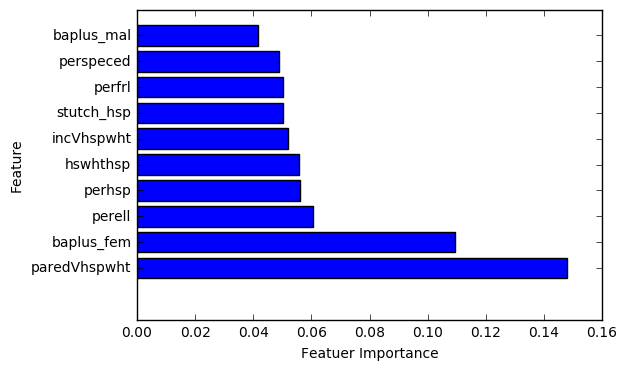

Score for validation set: 0.648685040706


In [216]:
# Decision Tree Classifier performance for Hispanic students
tree_clf_performance(norm_df(X_train_hsp), y_train_hsp, norm_df(X_test_hsp), y_test_hsp, 10)

In [164]:
# Top covariates for black and Hispanic students
top_cvrts_blk = ['paredVblkwht', 'baplus_mal', 'incVblkwht', 'hswhtblk', 'perblk']
top_cvrts_hsp = ['paredVhspwht', 'baplus_fem', 'perell', 'perhsp', 'hswhthsp']

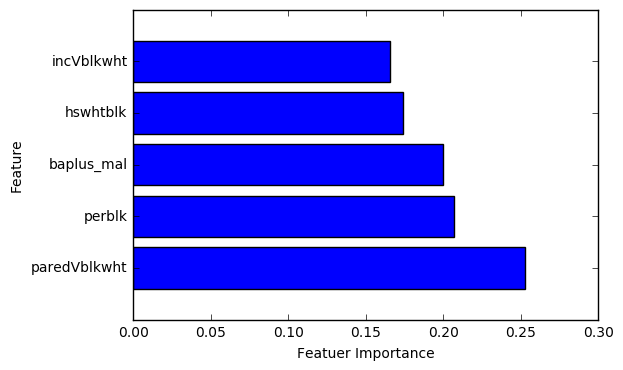

Weighted F1 score for validation set: 0.648091630169


In [229]:
# Decision Tree Classifier performance for black students using top covariates
tree_clf_performance(norm_df(X_train_blk[top_cvrts_blk]), y_train_blk, 
                     norm_df(X_test_blk[top_cvrts_blk]), y_test_blk, 5)

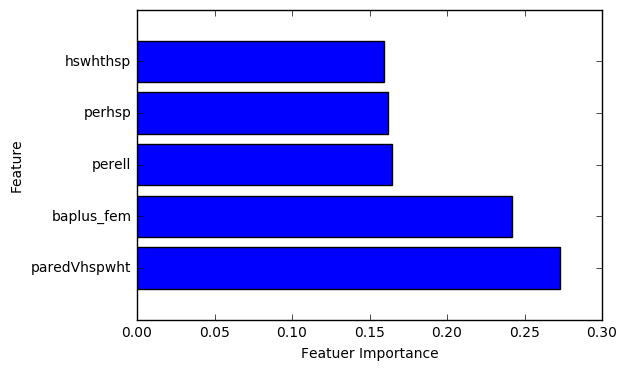

Weighted F1 score for validation set: 0.658830295296


In [230]:
# Decision Tree Classifier performance for black students using top covariates
tree_clf_performance(norm_df(X_train_hsp[top_cvrts_hsp]), y_train_hsp, 
                     norm_df(X_test_hsp[top_cvrts_hsp]), y_test_hsp, 5)

The income gap, percentage of males with a Bachelor's degree or higher, and the parent education gap are enough to maitain the predictive perofrmance of the original set of covariates. From this point on, the features are reduced to these covariates. This reduces dimensionality by elmininating features that do not covey much more information. The next step is to collect performance information on the Decision Tree Calssification, Logistic Regression, and Suppor Vector Machine algorithms. 

In [113]:
# Set of functions to go through different classifiers
## Function were adapted from Udacity's ML Nanodegree 
## This function trains the classifier on a given 
## classifier and set of features and labels.
## This function also keep track of time in order to
## quantify how long the training takes.
def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

## Predict labels; code takesn from ML Project 2
## This function predicts the labels and returns the score
## on a set of features and labels.
## This function also keep track of time in order to
## quantify how long the prediction takes.
def predict_labels(clf, features, target):
    print "Predicting labels using {}".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label = 'yes', average = 'weighted')
    ##TODO: Explain why added weighted

## Train and Predict, from Project 2, function is modified for classification
## This function combines the previous to functions to summarize
## the performance of a classifier for a set of 
## training and validation data.
def train_predict(clf,X_train,y_train,X_test,y_test,gap_split):
    print "-------------------------------------"
    print "Training set size: {}".format(len(X_train))
    print "Validation set size: {}".format(len(X_test))
    train_classifier(clf,X_train,y_train.apply(gap_split))
    print "F1 score for training set: {}".format(predict_labels(clf,
                                      X_train,y_train.apply(gap_split)))
    print "F1 score for validation set: {}".format(predict_labels(clf,
                                  X_test,y_test.apply(gap_split)))

In [169]:
# Decistion Tree Classification for black students
clf = tree.DecisionTreeClassifier()
train_predict(clf, norm_df(X_train_blk[top_cvrts_blk]), y_train_blk, 
              norm_df(X_test_blk[top_cvrts_blk]), y_test_blk, gap_bin)

-------------------------------------
Training set size: 62507
Validation set size: 26790
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.210
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.014
F1 score for training set: 0.737115353196
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.006
F1 score for validation set: 0.64912086359


In [170]:
# Decistion Tree Classification for Hispanic students
clf = tree.DecisionTreeClassifier()
train_predict(clf, norm_df(X_train_hsp[top_cvrts_hsp]), y_train_hsp,
              norm_df(X_test_hsp[top_cvrts_hsp]), y_test_hsp, gap_bin)

-------------------------------------
Training set size: 71509
Validation set size: 30647
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.236
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.020
F1 score for training set: 0.735566195752
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.007
F1 score for validation set: 0.658759670538


In [172]:
# Logistic Regression Classification for black students
clf = LogisticRegression()
train_predict(clf, norm_df(X_train_blk[top_cvrts_blk]), y_train_blk, 
              norm_df(X_test_blk[top_cvrts_blk]), y_test_blk, gap_bin)

-------------------------------------
Training set size: 62507
Validation set size: 26790
Training LogisticRegression...
Done!
Training time (secs): 0.800
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.007
F1 score for training set: 0.591456595117
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.003
F1 score for validation set: 0.594583268744


In [173]:
# Logistic Regression Classification for Hispanic students
clf = LogisticRegression()
train_predict(clf, norm_df(X_train_hsp[top_cvrts_hsp]), y_train_hsp, 
              norm_df(X_test_hsp[top_cvrts_hsp]), y_test_hsp, gap_bin)

-------------------------------------
Training set size: 71509
Validation set size: 30647
Training LogisticRegression...
Done!
Training time (secs): 0.927
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.009
F1 score for training set: 0.539657235564
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.003
F1 score for validation set: 0.537677305503


In [174]:
# Support Vector Machines Classification for black students
clf = SVC()
train_predict(clf, norm_df(X_train_blk[top_cvrts_blk]), y_train_blk, 
              norm_df(X_test_blk[top_cvrts_blk]), y_test_blk, gap_bin)

-------------------------------------
Training set size: 62507
Validation set size: 26790
Training SVC...
Done!
Training time (secs): 106.555
Predicting labels using SVC
Done!
Prediction time (secs): 72.214
F1 score for training set: 0.572400044985
Predicting labels using SVC
Done!
Prediction time (secs): 30.756
F1 score for validation set: 0.571079938891


In [176]:
# Support Vector Machines Classification for Hispanic students
clf = SVC()
train_predict(clf, norm_df(X_train_hsp[top_cvrts_hsp]), y_train_hsp, 
              norm_df(X_test_hsp[top_cvrts_hsp]), y_test_hsp, gap_bin)

-------------------------------------
Training set size: 71509
Validation set size: 30647
Training SVC...
Done!
Training time (secs): 136.756
Predicting labels using SVC
Done!
Prediction time (secs): 91.713
F1 score for training set: 0.527565043153
Predicting labels using SVC
Done!
Prediction time (secs): 39.222
F1 score for validation set: 0.523823999174


In [231]:
def make_table(performance_matrix):
    table = DataFrame(performance_matrix,
                     columns = ['Machine Learning Model', 'Training Time (sec)', 
                                'F1 Training', 'F1 Validation'])
    plt.barh(range(len(table['Machine Learning Model'])), table['F1 Validation'], align='center')
    plt.yticks(range(len(table['Machine Learning Model'])), table['Machine Learning Model'])
    plt.xlabel('Weighted F1 Score')
    plt.show()
    return table

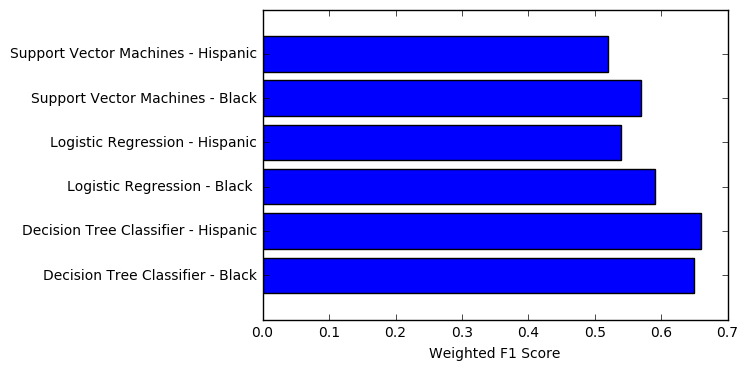

,Machine Learning Model,Training Time (sec),F1 Training,F1 Validation
0,Decision Tree Classifier - Black,0.21,0.73,0.65
1,Decision Tree Classifier - Hispanic,0.24,0.74,0.66
2,Logistic Regression - Black,0.80,0.59,0.59
3,Logistic Regression - Hispanic,0.93,0.54,0.54
4,Support Vector Machines - Black,106.55,0.57,0.57
5,Support Vector Machines - Hispanic,123.54,0.53,0.52


In [232]:
perf_mtrx_pre = [['Decision Tree Classifier - Black', 0.21, 0.73, 0.65],
            ['Decision Tree Classifier - Hispanic', 0.24, 0.74, 0.66],
            ['Logistic Regression - Black ', 0.8, 0.59, 0.59],
            ['Logistic Regression - Hispanic', 0.93, 0.54, 0.54],
            ['Support Vector Machines - Black', 106.55, 0.57, 0.57],
            ['Support Vector Machines - Hispanic', 123.54, 0.53, 0.52]]
make_table(perf_mtrx_pre)


## Methodology: Refinement


In [66]:
# Decistion Tree Classification refinement
## Function adapted from UL Nanodegree project
def tune_clf(clf, parameters, X_train, y_train, X_test, y_test, gap_split):
    ## Define parameters to be tuned
    f1scorer = make_scorer(f1_score, pos_label = 'yes', average = 'weighted')
    tuned_clf = GridSearchCV(clf, parameters, f1scorer)
    tuned_clf.fit(X_train, y_train.apply(gap_split))
    bestGridParams={}
    for p in tuned_clf.best_params_:
        bestGridParams[p]=tuned_clf.best_params_[p] 
    clf.set_params(**bestGridParams)
    train_predict(clf,X_train,y_train,X_test,y_test,gap_split)
    print bestGridParams
    return 


In [183]:
clf = tree.DecisionTreeClassifier()
parameter_grid = {'criterion': ['gini', 'entropy'],
                 'max_depth': range(15, 40, 1)}
tune_clf(clf, parameter_grid, norm_df(X_train_blk[top_cvrts_blk]), y_train_blk, 
         norm_df(X_test_blk[top_cvrts_blk]), y_test_blk, gap_bin)

-------------------------------------
Training set size: 62507
Validation set size: 26790
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.199
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.015
F1 score for training set: 0.725537990136
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.005
F1 score for validation set: 0.654893349288
{'criterion': 'entropy', 'max_depth': 16}


In [184]:
clf = tree.DecisionTreeClassifier()
parameter_grid = {'criterion': ['gini', 'entropy'],
                 'max_depth': range(15, 40, 1)}
tune_clf(clf, parameter_grid, norm_df(X_train_hsp[top_cvrts_hsp]), y_train_hsp, 
         norm_df(X_test_hsp[top_cvrts_hsp]), y_test_hsp, gap_bin)

-------------------------------------
Training set size: 71509
Validation set size: 30647
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.211
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.017
F1 score for training set: 0.716749926458
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.006
F1 score for validation set: 0.65828077457
{'criterion': 'gini', 'max_depth': 16}


In [186]:
clf = LogisticRegression()
parameter_grid = {'penalty': ['l1', 'l2'],
                 'C': [1, 10, 100, 200, 400]}
tune_clf(clf, parameter_grid, norm_df(X_train_blk[top_cvrts_blk]), y_train_blk, 
         norm_df(X_test_blk[top_cvrts_blk]), y_test_blk, gap_bin)

-------------------------------------
Training set size: 62507
Validation set size: 26790
Training LogisticRegression...
Done!
Training time (secs): 0.886
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.009
F1 score for training set: 0.592224938013
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.002
F1 score for validation set: 0.594453614933
{'penalty': 'l2', 'C': 200}


In [187]:
clf = LogisticRegression()
parameter_grid = {'penalty': ['l1', 'l2'],
                 'C': [1, 10, 100, 200, 400]}
tune_clf(clf, parameter_grid, norm_df(X_train_hsp[top_cvrts_hsp]), y_train_hsp, 
         norm_df(X_test_hsp[top_cvrts_hsp]), y_test_hsp, gap_bin)

-------------------------------------
Training set size: 71509
Validation set size: 30647
Training LogisticRegression...
Done!
Training time (secs): 1.077
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.016
F1 score for training set: 0.540879224156
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.004
F1 score for validation set: 0.539250922235
{'penalty': 'l2', 'C': 100}


In [188]:
clf = SVC()
parameter_grid = {'C': [0.1, 1, 10],
                 'gamma': [0.3, 1.3]}
tune_clf(clf, parameter_grid, norm_df(X_train_blk[top_cvrts_blk]), y_train_blk, 
         norm_df(X_test_blk[top_cvrts_blk]), y_test_blk, gap_bin)

-------------------------------------
Training set size: 62507
Validation set size: 26790
Training SVC...
Done!
Training time (secs): 301.358
Predicting labels using SVC
Done!
Prediction time (secs): 69.506
F1 score for training set: 0.596488797534
Predicting labels using SVC
Done!
Prediction time (secs): 29.566
F1 score for validation set: 0.598408768397
{'C': 10, 'gamma': 1.3}


In [199]:
clf = SVC()
parameter_grid = {'C': [0.1, 1, 10],
                 'gamma': [0.3, 1.3]}
tune_clf(clf, parameter_grid, norm_df(X_train_hsp[top_cvrts_hsp]), y_train_hsp, 
         norm_df(X_test_hsp[top_cvrts_hsp]), y_test_hsp, gap_bin)

-------------------------------------
Training set size: 71509
Validation set size: 30647
Training SVC...
Done!
Training time (secs): 469.673
Predicting labels using SVC
Done!
Prediction time (secs): 89.030
F1 score for training set: 0.544995985959
Predicting labels using SVC
Done!
Prediction time (secs): 37.825
F1 score for validation set: 0.54273817475
{'C': 10, 'gamma': 1.3}


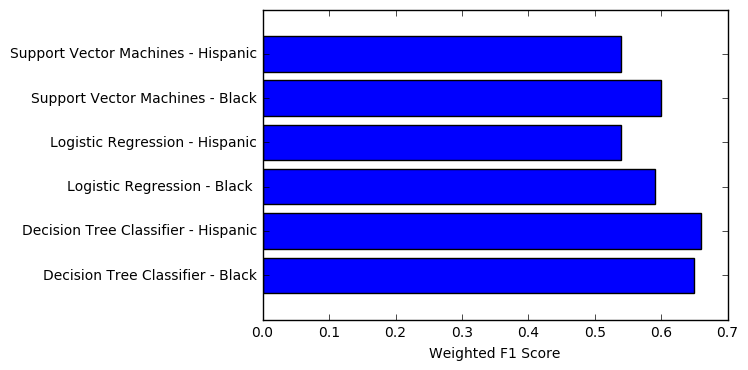

,Machine Learning Model,Training Time (sec),F1 Training,F1 Validation
0,Decision Tree Classifier - Black,0.20,0.73,0.65
1,Decision Tree Classifier - Hispanic,0.21,0.72,0.66
2,Logistic Regression - Black,0.89,0.59,0.59
3,Logistic Regression - Hispanic,1.07,0.54,0.54
4,Support Vector Machines - Black,301.36,0.60,0.60
5,Support Vector Machines - Hispanic,469.67,0.54,0.54


In [233]:
# Create molde performance plot and table after parameter tuning
perf_mtrx_post = [['Decision Tree Classifier - Black', 0.20, 0.73, 0.65],
            ['Decision Tree Classifier - Hispanic', 0.21, 0.72, 0.66],
            ['Logistic Regression - Black ', 0.89, 0.59, 0.59],
            ['Logistic Regression - Hispanic', 1.07, 0.54, 0.54],
            ['Support Vector Machines - Black', 301.36, 0.60, 0.60],
            ['Support Vector Machines - Hispanic', 469.67, 0.54, 0.54]]
make_table(perf_mtrx_post)

## Results: Model Evaluation and Final Test Set Validation

In this section, run models on final test sets to determine performance. As described earlier, the final test set is the data for academic year 2013. 


In [239]:
# Run Dummy Classifier with tuned parameters on 2013 academic - black students
dummy_clf(norm_df(X_train_blk[top_cvrts_blk]), y_train_blk, 
          norm_df(df_blk_test[top_cvrts_blk]), df_blk_test.gap.apply(gap_bin))

Weighted F1 score for validation set: 0.230936511269


In [240]:
# Run Dummy Classifier with tuned parameters on 2013 academic - Hispanic students
dummy_clf(norm_df(X_train_hsp[top_cvrts_hsp]), y_train_hsp,
         norm_df(df_hsp_test[top_cvrts_hsp]), df_hsp_test.gap.apply(gap_bin))


Weighted F1 score for validation set: 0.211710552858


In [189]:
# Run Decision Tree Classifier with tuned parameters on 2013 academic - black students
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=16)
train_predict(clf, norm_df(X_train_blk[top_cvrts_blk]), y_train_blk, 
              norm_df(df_blk_test[top_cvrts_blk]), df_blk_test.gap, gap_bin)

-------------------------------------
Training set size: 62507
Validation set size: 19368
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.203
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.013
F1 score for training set: 0.725537990136
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.002
F1 score for validation set: 0.620554624241


In [190]:
# Run Decision Tree Classifier with tuned parameters on 2013 academic - Hispanic students
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=16)
train_predict(clf, norm_df(X_train_hsp[top_cvrts_hsp]), y_train_hsp, 
              norm_df(df_hsp_test[top_cvrts_hsp]), df_hsp_test.gap, gap_bin)

-------------------------------------
Training set size: 71509
Validation set size: 24964
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.218
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.015
F1 score for training set: 0.716762466519
Predicting labels using DecisionTreeClassifier
Done!
Prediction time (secs): 0.003
F1 score for validation set: 0.619452333558


In [193]:
# Run Logistic Regression with tuned parameters on 2013 academic - black students
clf = LogisticRegression(penalty='l2', C=200)
train_predict(clf, norm_df(X_train_blk[top_cvrts_blk]), y_train_blk, 
              norm_df(df_blk_test[top_cvrts_blk]), df_blk_test.gap, gap_bin)

-------------------------------------
Training set size: 62507
Validation set size: 19368
Training LogisticRegression...
Done!
Training time (secs): 0.940
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.009
F1 score for training set: 0.592224938013
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.003
F1 score for validation set: 0.570488354475


In [195]:
# Run Logistic Regression with tuned parameters on 2013 academic - Hispanic students
clf = LogisticRegression(penalty='l2', C=100)
train_predict(clf, norm_df(X_train_hsp[top_cvrts_hsp]), y_train_hsp, 
              norm_df(df_hsp_test[top_cvrts_hsp]), df_hsp_test.gap, gap_bin)

-------------------------------------
Training set size: 71509
Validation set size: 24964
Training LogisticRegression...
Done!
Training time (secs): 1.095
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.009
F1 score for training set: 0.540879224156
Predicting labels using LogisticRegression
Done!
Prediction time (secs): 0.003
F1 score for validation set: 0.552242336029


In [200]:
# Run Support Vector Machines with tuned parameters on 2013 academic - black students
clf = SVC(C=10, gamma=1.3)
train_predict(clf, norm_df(X_train_blk[top_cvrts_blk]), y_train_blk, 
              norm_df(df_blk_test[top_cvrts_blk]), df_blk_test.gap, gap_bin)

-------------------------------------
Training set size: 62507
Validation set size: 19368
Training SVC...
Done!
Training time (secs): 294.372
Predicting labels using SVC
Done!
Prediction time (secs): 67.517
F1 score for training set: 0.596488797534
Predicting labels using SVC
Done!
Prediction time (secs): 20.852
F1 score for validation set: 0.57066328641


In [201]:
# Run Support Vector Machines with tuned parameters on 2013 academic - Hispanic students
clf = SVC(C=10, gamma=1.3)
train_predict(clf, norm_df(X_train_hsp[top_cvrts_hsp]), y_train_hsp, 
              norm_df(df_hsp_test[top_cvrts_hsp]), df_hsp_test.gap, gap_bin)

-------------------------------------
Training set size: 71509
Validation set size: 24964
Training SVC...
Done!
Training time (secs): 477.743
Predicting labels using SVC
Done!
Prediction time (secs): 92.319
F1 score for training set: 0.544995985959
Predicting labels using SVC
Done!
Prediction time (secs): 32.474
F1 score for validation set: 0.562074192977


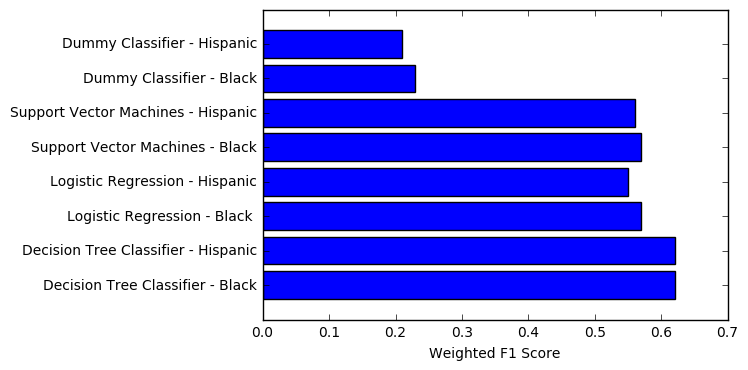

,Machine Learning Model,Training Time (sec),F1 Training,F1 Validation
0,Decision Tree Classifier - Black,0.20,0.73,0.62
1,Decision Tree Classifier - Hispanic,0.22,0.72,0.62
2,Logistic Regression - Black,0.94,0.59,0.57
3,Logistic Regression - Hispanic,1.10,0.54,0.55
4,Support Vector Machines - Black,294.30,0.59,0.57
5,Support Vector Machines - Hispanic,477.74,0.54,0.56
6,Dummy Classifier - Black,0.01,0.46,0.23
7,Dummy Classifier - Hispanic,0.01,0.45,0.21


In [241]:
# Create final performance table and plot comparing all ML models used in the project
perf_mtrx_test = [['Decision Tree Classifier - Black', 0.20, 0.73, 0.62],
            ['Decision Tree Classifier - Hispanic', 0.22, 0.72, 0.62],
            ['Logistic Regression - Black ', 0.94, 0.59, 0.57],
            ['Logistic Regression - Hispanic', 1.1, 0.54, 0.55],
            ['Support Vector Machines - Black', 294.3, 0.59, 0.57],
            ['Support Vector Machines - Hispanic', 477.74, 0.54, 0.56],
                  ['Dummy Classifier - Black', 0.01, 0.46, 0.23], ## Including the regressor
                  ['Dummy Classifier - Hispanic', 0.01, 0.45, 0.21]] ## for a final visual comparison.
                  
make_table(perf_mtrx_test)